In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.908836  0.836859  0.267449  0.250209  0.111658 -0.984887 -0.158178   
  1   0.457641 -0.267987 -0.099077  0.860712  0.366995 -1.272382 -0.441346   
  2   0.095620  0.124479  0.379503  0.107342 -0.401775  0.147902  0.714548   
  3  -0.366031 -0.886999 -1.247118 -0.378463 -0.070916 -0.742827  0.550152   
  4  -0.156304  0.054289  0.574473  0.903929 -0.075318 -0.482088  0.223244   
  5  -0.415846  0.115944  0.930987  0.143004  0.101035 -0.366441 -0.083622   
  6  -0.633597 -1.063333  0.377019  0.816543  0.183273 -0.831521  0.467854   
  7  -0.346338  0.674168 -0.158871  0.045537  1.492272  0.013668  0.873764   
  8  -0.467735  0.560501 -0.475478  0.034181  0.536719 -0.319684  0.646232   
  9   0.666154 -0.223207  0.663426  0.131729 -0.430265 -1.380241  1.320329   
  10 -0.309982  0.243248  0.428825  0.059052 -0.350547 -1.720413 -0.477799   
  11  0.023643 -0.186485 -0.272839 -0.369741 -1.206981 -0.806668 -0.335843   
  12  0.984809  0.432829 -0.713694 -0.455904  0.356915 -0.078941  0.201537   
  13  0.363734 -0.658050  0.385796 -0.768771 -0.685828 -0.404121  1.013207   
  14 -0.343324  0.755407 -0.626288  0.142815  0.870925  0.126301  1.199714   
  15 -0.562429 -0.386761 -0.734656 -0.918735 -1.053314 -1.666288 -0.061880   
  16 -0.119467  0.035427 -0.210091 -0.510688 -1.196885  0.069007 -0.196077   
  17  0.690224  0.152690 -0.114042 -0.186034 -0.349195 -0.693257  0.536437   
  18 -0.184523  0.803632 -1.111786  0.054556  0.347660 -0.771503 -0.386661   
  19  0.674609  0.502919  0.315251 -0.441881  0.134937 -1.273788 -0.766342   
  20  0.788440  0.817985  0.386274 -0.208171  0.385002 -0.220747  0.172033   
  21  1.466123 -0.213655  0.246642  0.116504  0.418512 -1.229723  0.640952   
  22 -0.227790 -0.833328 -0.323829 -0.392681 -0.710573  0.339960  0.159305   
  23 -0.101125 -0.199243  0.351364 -1.016132  0.196283  0.181943  0.557490   
  24  1.104317  0.831571 -0.093887  0.162111  1.413800 -0.773972 -0.681089   
1 0   0.142506  0.156132 -1.572036 -1.143790  0.309009  0.132066  0.750603   
  1  -0.621742  0.186407  0.112843 -0.267839 -0.011001 -0.205348 -0.280358   
  2  -0.096634  0.420559  1.048599  0.438128  0.195401 -0.232287  0.746544   
  3   0.399302  0.152278 -1.136152 -0.929109  0.480755  0.257789  0.729228   
  4  -0.216156  0.226349 -0.387022 -0.296732  0.657013  0.577653 -0.850306   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.103106  0.553980 -0.595918  ... -0.894303 -0.804964  0.187609   
  1   0.282162  0.644388 -0.073766  ...  0.076762  0.365616 -0.004916   
  2   0.779749 -0.038421  1.372967  ... -0.409918  0.863984  0.758846   
  3   0.972990  0.110221  0.113437  ... -0.491113  0.567861 -0.185985   
  4   0.316311  0.084393  0.852844  ... -0.416153  0.112032  0.436110   
  5  -0.529044  0.689156  0.026686  ... -0.832030  0.388160  0.634358   
  6   0.537575 -0.828941 -0.294697  ... -0.770328 -0.096807  0.534680   
  7  -0.726146  0.474307  0.101214  ... -0.320697 -0.065499  0.537957   
  8   0.552482  0.356910  0.195062  ... -0.164149  0.314643  0.012221   
  9   0.833050  1.234346  0.331701  ... -0.354271  0.775601 -0.185884   
  10  0.187195  0.302249 -0.078620  ... -1.501800 -0.517721  0.644627   
  11 -0.058007 -0.490895 -0.097349  ... -1.296975 -0.176234  0.010276   
  12  0.727803  0.197575  0.012430  ...  0.084187 -0.187809  0.158590   
  13  0.001327 -0.396610 -0.710417  ... -0.608302  0.599715  0.020654   
  14  0.193664 -0.358733  0.545767  ... -0.682471 -0.293836  0.103891   
  15  0.558089 -0.446062  0.773043  ... -0.173636  0.314276  0.654729   
  16  0.223446  0.877433  0.466664  ... -0.341819  0.499145 -0.416129   
  17 -0.067213 -0.437134  0.018755  ... -0.546706 -0.390239  0.102053   
  18  0.247670  0.092112  0.571455  ...  0.098735  0.350565  0.608263   
  19 -0.438131  0.669911 -0.197333  ... -0.694294  0.953935  0.490009   
  20 -0.706015  0.023564 -0.927894  ... -0.301633  1.364073 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef  std err          t          P>|t|     2.5 %    97.5 %
D  0.979004  0.04119  23.767955  7.166367e-125  0.898273  1.059735


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



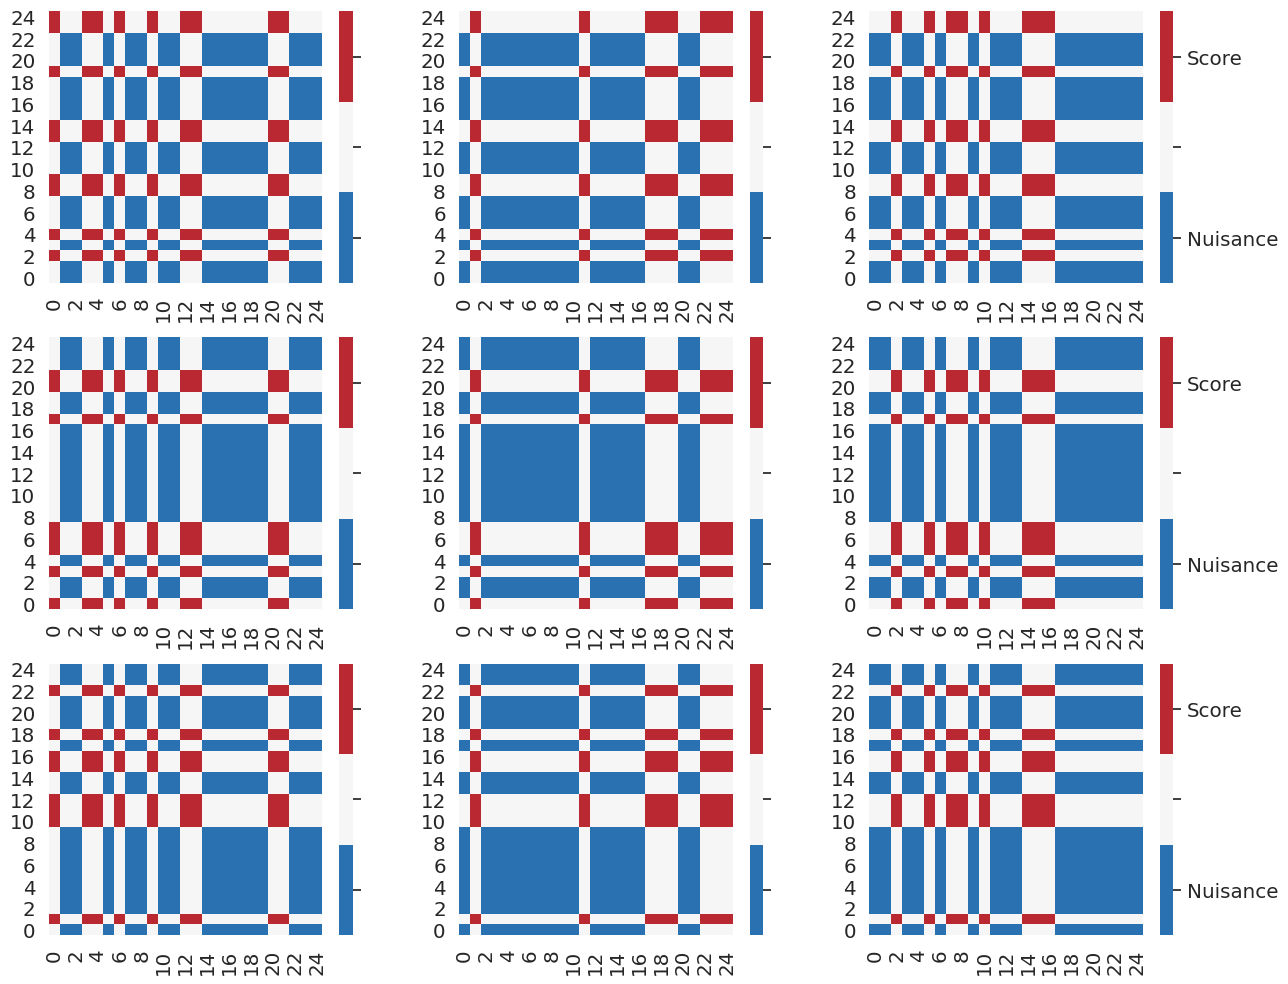

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



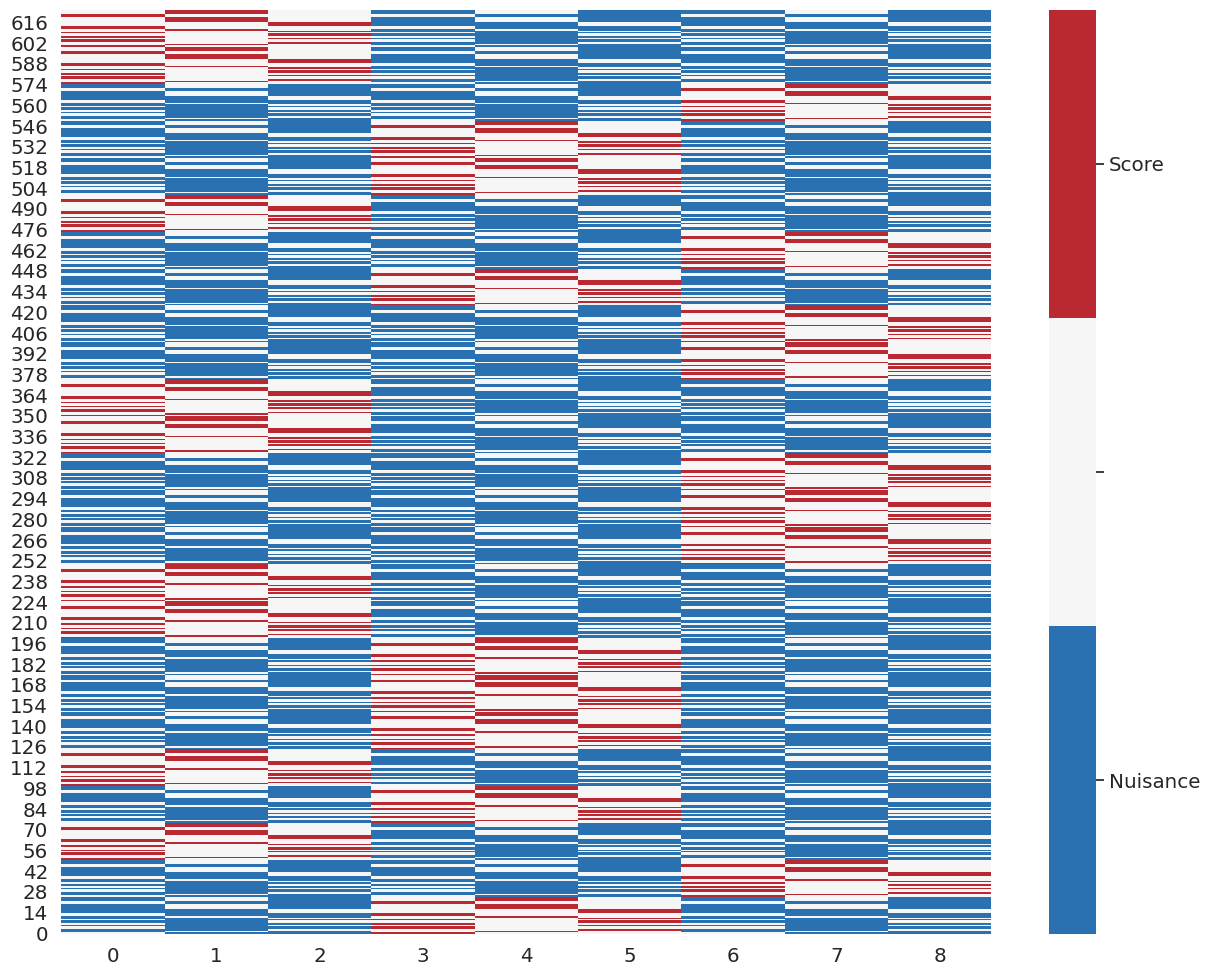

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])